# Example of Limit/Sensi Calculation

I rebased the wimp files to have 1e-48 cross sections to aid in fitting

In [1]:
load_files_from_cache = False

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from binference.toymc_running import toymc_to_sbatch_call_array, compute_neyman_thresholds, toymc_to_sbatch_call
from binference.utils import read_neyman_threshold

from inference_interface import toyfiles_to_numpy

from subprocess import call
from time import gmtime, strftime, sleep

import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import pkg_resources
import scipy.stats as sps

## Specify a few batches of toyMCs to compute discovery power and Neyman thresholds first:  

In [35]:
generate_args = dict(
    signal_rate_multiplier=0.01,
    er_rate_multiplier=1.,
    atnu_rate_multiplier=1.,
    cevns_rate_multiplier=1.,
    solarnu_rate_multiplier=1.,
    )

parameters_to_vary = dict(
                signal_expectation=np.linspace(0,40,21),
                #signal_expectation=[0.],
                wimp_mass = [100],
)


parameters_in_common = dict(
                extra_args = ["true","null","free"],
                output_filename = "darwin_test/toymc_power_wimp_mass_{wimp_mass:d}_signal_expectation_{signal_expectation:.2f}.hdf5",         
                generate_args = generate_args, 
                n_mc = 5000, #sufficient for Neyman computation first try
                guess = dict(signal_rate_multiplier=0.00000),
                livetime = 200., #ty
                n_batch = 10,)

### use the toymc_to_sbatch_call_array to give run list 
loop over the product of all iterables in parameters_to vary, keep 
"parameters_in_common" together. 

In [36]:
fnames, calls = toymc_to_sbatch_call_array(parameters_to_vary=parameters_to_vary, parameters_in_common=parameters_in_common)

In [37]:
print(len(calls),"calls will be submitted")

210 calls will be submitted


###  send runs to sbatch via command line calls: 

In [39]:
for c in calls: 
    call(c)
    sleep(0.2)

Submitting 210 jobs
Submitted batch job 25715192
Submitted batch job 25715193
Submitted batch job 25715194
Submitted batch job 25715195
Submitted batch job 25715196
Submitted batch job 25715197
Submitted batch job 25715198
Submitted batch job 25715199
Submitted batch job 25715200
Submitted batch job 25715201
Submitted batch job 25715202
Submitted batch job 25715203
Submitted batch job 25715204
Submitted batch job 25715205
Submitted batch job 25715206
Submitted batch job 25715207
Submitted batch job 25715208
Submitted batch job 25715209
Submitted batch job 25715211
Submitted batch job 25715212
Submitted batch job 25715213
Submitted batch job 25715214
Submitted batch job 25715215
Submitted batch job 25715216
Submitted batch job 25715217
Submitted batch job 25715218
Submitted batch job 25715219
Submitted batch job 25715220
Submitted batch job 25715221
Submitted batch job 25715222
Submitted batch job 25715223
Submitted batch job 25715224
Submitted batch job 25715225
Submitted batch job 257

### Read in some results: 

In [17]:
signal_expectations=np.linspace(0,40,21)
llrs_null = []
llrs_true = []
wimp_mass = 10
if not load_files_from_cache: 
    for se in signal_expectations: 
        results = toyfiles_to_numpy("darwin_test/toymc_power_wimp_mass_{wimp_mass:d}_signal_expectation_{signal_expectation:.2f}*.hdf5".format(wimp_mass=wimp_mass, signal_expectation=se))
        llrs_null.append( 2*(results["free"]["ll"]-results["null"]["ll"]) )
        llrs_true.append( 2*(results["free"]["ll"]-results["true"]["ll"]) )
else: 
    file_name = pkg_resources.resource_filename("binference","data/tutorial_cache/binference_tutorial_neyman_llrs.npz")
    with np.load(file_name) as cache_file: 
        llrs_null = cache_file["llrs_null"]
        llrs_true = cache_file["llrs_true"]
        
    

## Discovery power 
shows the power to be above the p_value_threshold for each signal size

In [20]:
p_value_threshold = 0.01
llr_threshold = sps.scoreatpercentile(llrs_null[0],100-100*p_value_threshold)

In [21]:
powers = np.zeros(len(llrs_null))
for i,llrn in enumerate(llrs_null):
    powers[i] = 1-0.01*sps.percentileofscore(llrn,llr_threshold)

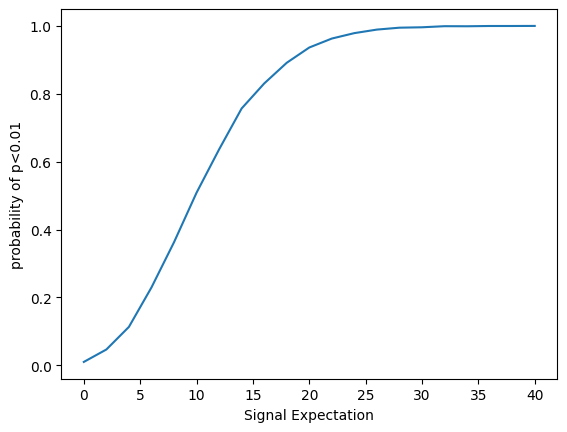

In [22]:
plt.clf()
plt.plot(signal_expectations, powers)
plt.xlabel("Signal Expectation")
plt.ylabel("probability of p<{:.2f}".format(p_value_threshold))
plt.show()

## Neyman threshold 

### Compute it: 
the compute_neyman takes the same kind of dict arguments as the run: 

note that the signal rate is not in the "to vary" slot but rather as a wildcard-- we want all different signal expectations (and n_mc, n_batch) to be grouped together

In [44]:
generate_args = dict(
    signal_rate_multiplier=0.0,
    er_rate_multiplier=1.,
    atnu_rate_multiplier=1.,
    cevns_rate_multiplier=1.,
    solarnu_rate_multiplier=1.,
    )

parameters_to_vary = dict(
                wimp_mass = [10,20,50,200, 1000],
)
parameters_in_common = dict(
                extra_args = ["free","null","true"],
                output_filename = "darwin_test/toymc_power_wimp_mass_{wimp_mass:d}_signal_expectation_{signal_expectation:.2f}.hdf5",
                generate_args = generate_args,
                livetime=200.,
                )
parameters_as_wildcards = ["signal_expectation","n_mc","n_batch"]

file_name_pattern = "darwin_test/toymc_power_wimp_mass_{wimp_mass:d}_signal_expectation_{signal_expectation:.2f}_{n_batch:d}.hdf5"


In [45]:
compute_neyman_thresholds(file_name_pattern, "darwin_test/thresholds.hdf5", parameters_to_vary=parameters_to_vary, parameters_in_common=parameters_in_common, parameters_as_wildcards=parameters_as_wildcards) 

Reading files for pattern: darwin_test/toymc_power_wimp_mass_10_signal_expectation_*_*.hdf5
Reading files for pattern: darwin_test/toymc_power_wimp_mass_20_signal_expectation_*_*.hdf5
Reading files for pattern: darwin_test/toymc_power_wimp_mass_50_signal_expectation_*_*.hdf5
Reading files for pattern: darwin_test/toymc_power_wimp_mass_200_signal_expectation_*_*.hdf5
Reading files for pattern: darwin_test/toymc_power_wimp_mass_1000_signal_expectation_*_*.hdf5


### Read Neyman threshold: 
Rather low stats in this example.. 

1.8221874369779167
21.40226154027888
44044.340941896146
33.066197550569015
19144.22510136222
4.162649166757303


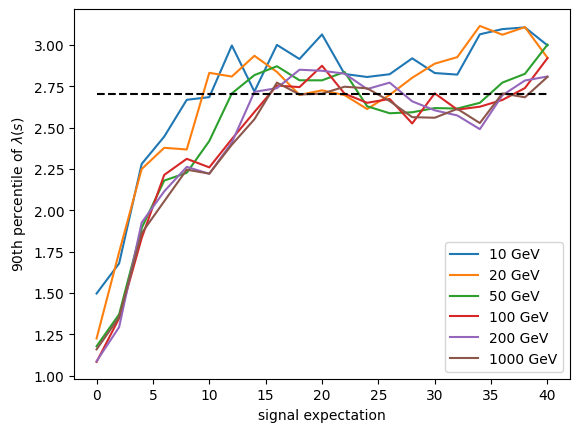

In [42]:
plt.clf()
for wimp_mass in parameters_to_vary["wimp_mass"]:
    if not load_files_from_cache:
        signal_expectations, threshold, nominal_signal_expectation = read_neyman_threshold("darwin_test/thresholds.hdf5",parameter_values={"wimp_mass":wimp_mass},confidence_level=0.9)
        print(nominal_signal_expectation)
    else:
        file_name = pkg_resources.resource_filename("binference","data/tutorial_cache/thresholds.hdf5")
        signal_expectations, threshold, nominal_signal_expectation = read_neyman_threshold(file_name,parameter_values={"wimp_mass":wimp_mass},confidence_level=0.9)
    plt.plot(signal_expectations, threshold,label="{:d} GeV".format(wimp_mass))
plt.plot(signal_expectations, sps.chi2(1).ppf(0.9)*np.ones(len(signal_expectations)),linestyle="--",color="k")
plt.legend()
plt.xlabel("signal expectation")
plt.ylabel("90th percentile of $\\lambda(s)$")
plt.show()

# Set up sensitivity computation: 

In [26]:
generate_args = dict(
    signal_rate_multiplier=0.0,
    er_rate_multiplier=1.,
    atnu_rate_multiplier=1.,
    cevns_rate_multiplier=1.,
    solarnu_rate_multiplier=1.,
    )

parameters_to_vary = dict(
                signal_expectation=[0],
                wimp_mass = [10,20,50,200,1000],
)
parameters_in_common = dict(
                extra_args = ["null","free"],
                output_filename = "darwin_test/toymc_sensi_wimp_mass_{wimp_mass:d}_signal_expectation_{signal_expectation:.2f}.hdf5",
                generate_args = generate_args, 
                compute_confidence_interval = True, 
                limit_threshold = "darwin_test/thresholds.hdf5",
                livetime = 200.,
                n_mc = 10000,
                #guess = dict(signal_rate_multiplier=0),
                n_batch = 100,)

In [27]:
fnames, calls = toymc_to_sbatch_call_array(parameters_to_vary=parameters_to_vary, parameters_in_common=parameters_in_common)   

In [28]:
print(len(fnames),"toyMCs will be submitted")

500 toyMCs will be submitted


In [29]:
for c in calls: 
    call(c)
    sleep(0.2)

Submitting 500 jobs
Submitted batch job 25713464
Submitted batch job 25713465
Submitted batch job 25713466
Submitted batch job 25713467
Submitted batch job 25713468
Submitted batch job 25713469
Submitted batch job 25713470
Submitted batch job 25713471
Submitted batch job 25713472
Submitted batch job 25713473
Submitted batch job 25713474
Submitted batch job 25713475
Submitted batch job 25713476
Submitted batch job 25713477
Submitted batch job 25713478
Submitted batch job 25713479
Submitted batch job 25713480
Submitted batch job 25713481
Submitted batch job 25713482
Submitted batch job 25713484
Submitted batch job 25713485
Submitted batch job 25713486
Submitted batch job 25713487
Submitted batch job 25713488
Submitted batch job 25713489
Submitted batch job 25713490
Submitted batch job 25713491
Submitted batch job 25713492
Submitted batch job 25713493
Submitted batch job 25713494
Submitted batch job 25713495
Submitted batch job 25713496
Submitted batch job 25713497
Submitted batch job 257

## Collect for sensitivity:  

In [30]:
parameters_to_vary = dict(
                signal_expectation=[0],
                wimp_mass = [10,20,50, 200,1000],
)

ul_distros = {}
if not load_files_from_cache:
    for wimp_mass in parameters_to_vary["wimp_mass"]:
        try:
            results = toyfiles_to_numpy("darwin_test/toymc_sensi_wimp_mass_{wimp_mass:d}_signal_expectation_*.hdf5".format(wimp_mass=wimp_mass))
            ul_distros[wimp_mass] = results["free"]["ul"]
        except:
            pass #nice to be able to plot when partial results are ready
else:
    file_name = pkg_resources.resource_filename("binference","data/tutorial_cache/binference_tutorial_sensi_uls.npz")
    with np.load(file_name, allow_pickle=True) as cache_file: 
        ul_distros = cache_file["ul_distros"].item()
 

In [31]:
sigma_plot = np.linspace(-2,2,5)
wimp_mass_plot = np.array(sorted(ul_distros.keys()))
ul_lines = {s:np.zeros(len(wimp_mass_plot)) for s in sigma_plot}
for i, wimp_mass in enumerate(wimp_mass_plot):
    uls = ul_distros[wimp_mass]
    for j, sigma in enumerate(sigma_plot):
        ul_lines[sigma][i] = np.percentile(uls, 100*sps.norm().cdf(sigma))

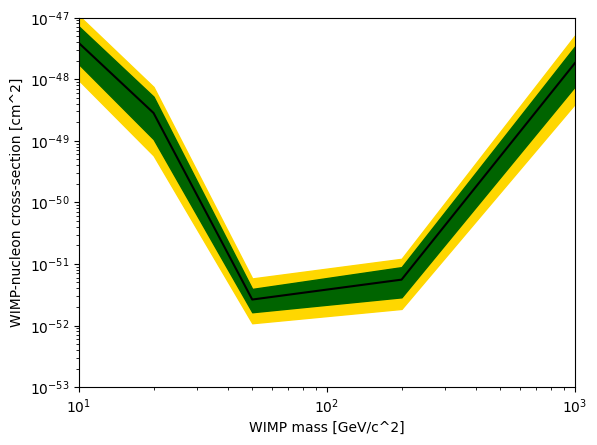

In [34]:
plt.clf()
plt.fill_between(wimp_mass_plot, ul_lines[-2]*1e-48,ul_lines[-1]*1e-48, color="gold")
plt.fill_between(wimp_mass_plot, ul_lines[1]*1e-48,ul_lines[2]*1e-48, color="gold")
plt.fill_between(wimp_mass_plot, ul_lines[-1]*1e-48,ul_lines[1]*1e-48, color="darkgreen")
plt.plot(wimp_mass_plot, ul_lines[0]*1e-48, color="k")
plt.xscale("log")
plt.yscale("log")
plt.xlim(10,1e3)
plt.ylim(1e-53,1e-47)
plt.xlabel("WIMP mass [GeV/c^2]")
plt.ylabel("WIMP-nucleon cross-section [cm^2]")
plt.show()